In [19]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from pathlib import Path
import matplotlib.pyplot as plt

In [134]:
from ecephys_analyses.psth import get_all_psth_data
from ecephys_analyses.data import paths, channel_groups
from ecephys.plot import plot_psth_heatmap
from ecephys.units.psth import get_normed_data


In [110]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [150]:
def make_psth_figures(
    subject, condition, sorting_condition,
    good_only=False,
    normalize='baseline_zscore', region='all',
    state=None, clim=None,
    save=False, show=True, output_dir=None,
):
    if output_dir is None:
        # Save in condition dir
        output_dir = paths.get_datapath(subject, condition, 'plots')
        output_dir.mkdir(exist_ok=True)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    print(
        f"Generate figures for {subject} {condition}, {state}, "
        f"{region}, good={good_only}, clim={clim}, output={output_dir}",
    )
    
    pop, all_psth, info, event_df = get_all_psth_data(
        subject, condition, sorting_condition,
        region=region, state=state, good_only=good_only
    )
    print("Done getting psth data")
    window = all_psth['window']
    binsize = all_psth['binsize']
    
    # Normalize psth
    assert all_psth['conditions'] is None
    psth_raw = all_psth['data'][0]
    psth_unsorted = get_normed_data(
        psth_raw, normalize=normalize,
        window=window, binsize=binsize
    )
    
    # Order by depth (bottom is tip of probe)
    unsorted_depths = list(info['depth'])
    perm = sorted(range(len(unsorted_depths)), key=lambda k: unsorted_depths[k], reverse=True)
    depths = np.array(unsorted_depths)[perm]
    psth_array = psth_unsorted[perm,:]
    
    # Get distance from surface of cortex
    surface_depth = channel_groups.depth_intervals[subject][condition]['cortex'][1]
    print('Surface depth', surface_depth)
    depths_from_surf = [
        (surface_depth - d) / 1000 for d in depths
    ] 

    # Plot a certain number of labels overall
    n_ticks = 10
    n_clust = psth_array.shape[0]
    tick_modulo = int(n_clust/n_ticks) + 1
    ylabels = depths_from_surf
    ylabels = np.array([
        None if i % tick_modulo != 0 else lbl
        for i, lbl in enumerate(ylabels[::-1])
    ])[::-1]
    
    fig, axes = plot_psth_heatmap(
        psth_array, ylabels, window, binsize, clim=clim,
        cbar_label='Average rate (Z-scored)'
    )
    
    # Title
    title=f"PSTH: {subject}, {condition}\n"
    if state is not None:
        title+=f"State={state}; "
    if region is not None:
        title+=f'Region={region}; '
    title += f'N={len(event_df)} pulses; N={psth_array.shape[0]} clusters'
    plt.title(title)
    plt.ylabel('Clusters\n(mm from surface)')
    print("Done getting plot")
    
    if show:
        plt.show()
    
    if save:
        filename = f"psth_{subject}_{condition}_{state}_region={region}_goodonly={good_only}_norm={normalize}_clim={clim}"
        print(f'save {filename}')
        fig.savefig(Path(output_dir)/(filename + '.png'))
    
    return fig, axes

Generate figures for Eugene 10-9-2020_NREM_depth1.5_imec0, None, all, good=False, clim=[-4, 4], output=/Volumes/neuropixel/Data/tom/catgt/CNPIX6-Eugene/10-9-2020_NREM_depth1.5_imec0/plots
N clusters (all)=351
Subset clusters: good_only=False, drop_noise=True, depths=None
Drop N=0/351 noise clusters
Subselect N = 351/351 clustersdone
Load events at path
N events = 91
Done getting psth data
Zscore by baseline
100
Surface depth 7660
Done getting plot


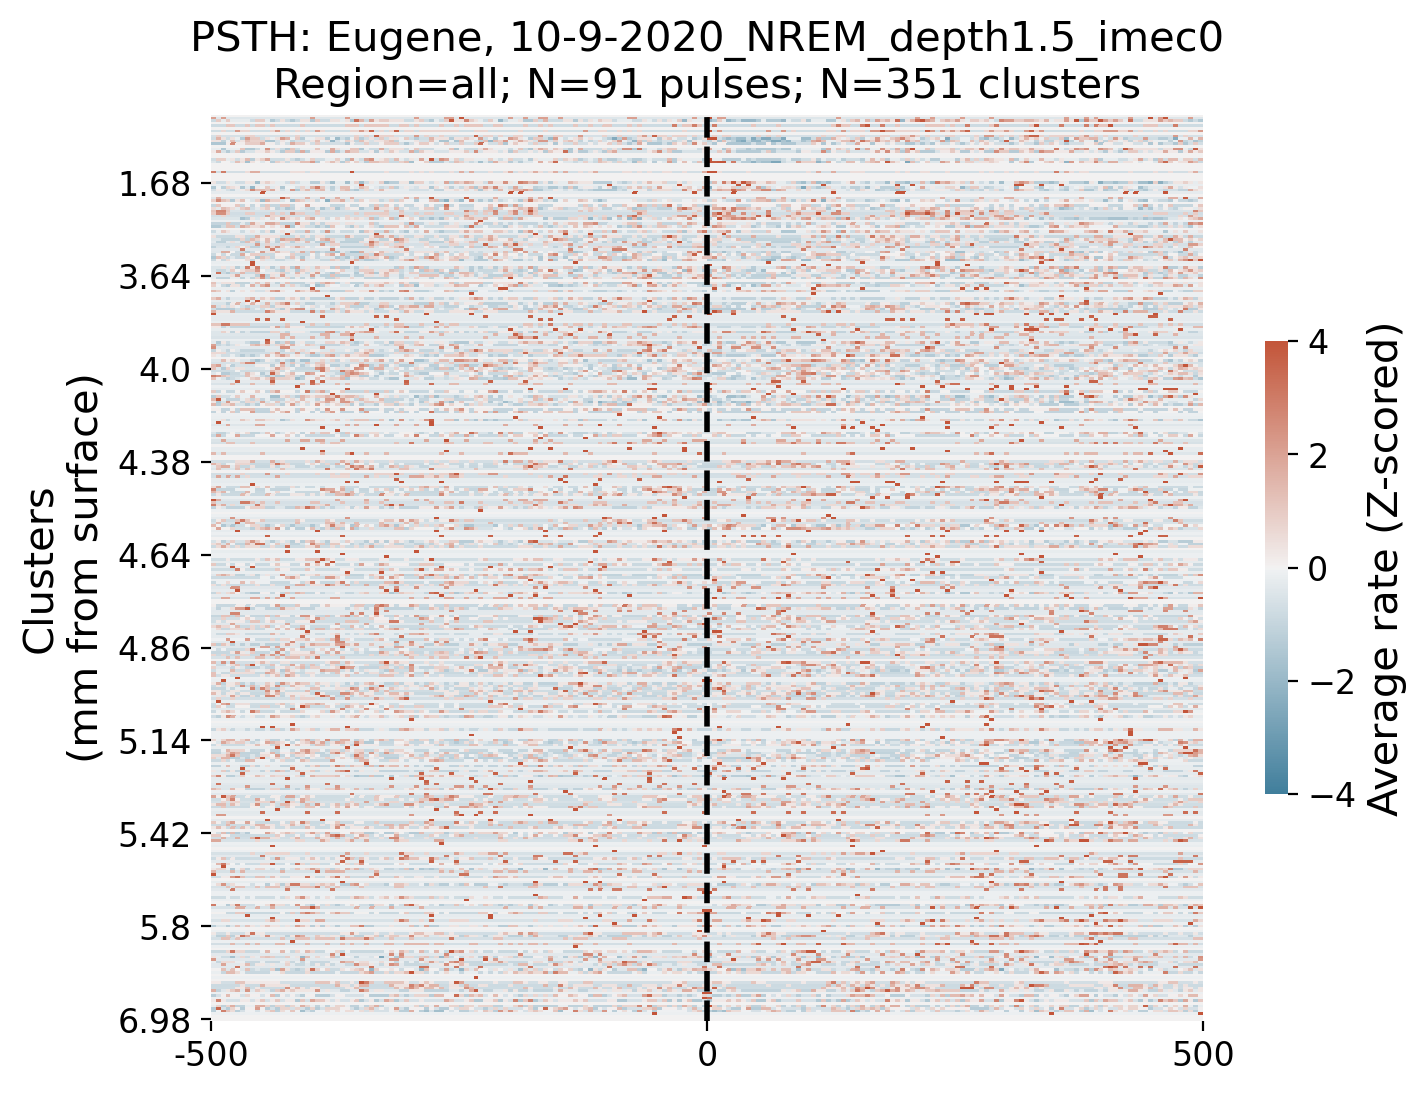

In [162]:
fix, ax = make_psth_figures(
    'Eugene', conditions[0], sorting_condition,
    good_only=False,
    normalize='baseline_zscore',
    region='all',
    state=None, clim=[-4, 4],
    save=False, show=True,
    output_dir=None,
)

# All

In [164]:
sorting_condition = 'ks2_5_catgt_df'

OUTPUT_DIR = None  # Save in subject/condition/plots

In [ ]:
clim_values = [
    [-4, 4],
]

good_only_values = [
    False,
    True
]

states = [
    None,
]

regions = [
    'cortex',
    'all',
]

subject = 'Eugene'
condition_group = 'eStim'

conditions = paths.get_conditions(subject, condition_group)
print(f"N={len(conditions)} conditions: {conditions}")

In [ ]:
n_jobs = 10

In [ ]:
if n_jobs == 1:
    for (
            condition,
            state,
            region, 
            good_only,
            clim
    ) in itertools.product(
        conditions, states, regions, good_only_values, clim_values
    ):
        make_psth_figures(
            subject,
            condition,
            sorting_condition,
            state=state,
            region=region,
            good_only=good_only,
            clim=clim,
            save=True,
            show=False,
            output_dir=OUTPUT_DIR,
        )
else:
    from joblib import Parallel, delayed
    
    def make_figures_parall( condition, state, region,  good_only, clim ):
        try:
            make_psth_figures(
                subject,
                condition,
                sorting_condition,
                state=state,
                region=region,
                good_only=good_only,
                clim=clim,
                save=True,
                show=False,
                output_dir=OUTPUT_DIR,
            )
        except Exception as e:
            print(f"failed :", subject, condition, state, region,  good_only, clim)
            print(e)
        
    Parallel(n_jobs=n_jobs, backend='multiprocessing')(
        delayed(make_figures_parall)(
            condition,
            state,
            region, 
            good_only,
            clim
        ) for (
            condition,
            state,
            region, 
            good_only,
            clim
        ) in itertools.product(
            conditions, states,
            regions, good_only_values, clim_values
        )
    )
    print('done')